In [4]:
import pandas as pd
import numpy as np
import math
from pulp import *
from tabulate import tabulate

def optimizer (x_ij, c_ij, d_i, n_0i, R, NUM_AREA):
    prob = LpProblem("Model", LpMaximize)

    m_ij = [[0]*NUM_AREA for _ in range(NUM_AREA)]
    y_ij = [[0]*NUM_AREA for _ in range(NUM_AREA)]
    n_1i = []
    for i in range(NUM_AREA):
        n_1i.append(LpVariable("n_1%d"%(i), 0, None, LpInteger))
        for j in range(NUM_AREA):
            y_ij[i][j] = LpVariable("y_%d%d"%(i,j), 0, None, LpInteger)
            if i!=j:
                m_ij[i][j] = LpVariable("m_%d%d"%(i,j), 0, None, LpInteger)

    # ========= CONSTRUCT LP ============ #

    # Objective
    prob += sum([R*y_ij[i][j]*x_ij[i][j] - m_ij[i][j]*c_ij[i][j] for i in range(NUM_AREA) for j in range(NUM_AREA)])

    # Subject To
    for j in range(NUM_AREA):
        # n_1i
        prob += n_1i[j] == n_0i[j] + sum(m_ij[i][j] for i in range(NUM_AREA)) - sum(m_ij[j][i] for i in range(NUM_AREA)), "Equation Area: %d"%j
        # n_0i
        prob += n_0i[j] >= sum(m_ij[j][i] for i in range(NUM_AREA)), "Moving Constrain: %d"%j
        # y_ij
        prob += sum(y_ij[j][i] for i in range(NUM_AREA)) <= d_i[j] ,"Total Demand: %d"%j
        prob += sum(y_ij[i][j]*x_ij[i][j] for i in range(NUM_AREA)) <= n_1i[j] ,"Total Available: %d"%j


    # ============== SOLVE ============= #
    prob.solve()
    return value(prob.objective)

In [5]:
NUM_AREA = 3
R = 9.03 # Revenue

# ========== DATA ============= #

x_ij = [[0.99, 0.68, 0.17], 
        [0.68, 0.962, 0.43], 
        [0.17,0.44,0.99]] # [[row]] - x00, x01, x10, x11, move cars from j to i

c_ij = [[0, 4.14, 6.52], 
        [4.14, 0, 5.18], 
        [6.52,5.18,0]] # c00, c01, c10, c11 # Move cars from i to j

c_control = [[0, 999, 6999], 
        [999, 0, 999], 
        [999,999,0]] # c00, c01, c10, c11 # Move cars from i to j

n_0i = [5,44,9999]

res = []

for d1 in range(80,200):
    d_i = [d1, 20,0]
    out = optimizer (x_ij, c_ij, d_i, n_0i, R, NUM_AREA)
    control = optimizer (x_ij, c_control, d_i, n_0i, R, NUM_AREA)
    res.append((out-control)/control)


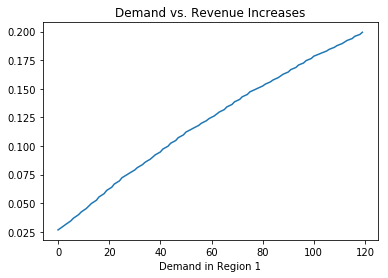

In [9]:
import matplotlib.pyplot as plt
plt.plot(res)
plt.xlabel("Demand in Region 1")
plt.title("Demand vs. Revenue Increases")
plt.show()